In [1]:
import math
import os
import pickle
from functools import partial

import numpy as np
import pandas as pd
import pyabc
import scipy.stats as stats
from fitmulticell import model as morpheus_model
from fitmulticell.sumstat import SummaryStatistics

from summary_stats import reduced_coordinates_to_sumstat, reduce_to_coordinates, compute_mean_summary_stats, cut_region

# get the job array id and number of processors
job_array_id = int(os.environ.get('SLURM_ARRAY_TASK_ID', 0))
n_procs = int(os.environ.get('SLURM_CPUS_PER_TASK', 1))
print(job_array_id)
on_cluster = False

0


In [2]:
if on_cluster:
    gp = '/home/jarruda_hpc/CellMigration/synth_data_params_bayesflow'
else:
    gp = os.getcwd()

# defining the mapping of parameter inside the model xml file. the dictionary name is for 
# parameter name, and the value are the mapping values, to get the map value for parameter 
# check here: https://fitmulticell.readthedocs.io/en/latest/example/minimal.html#Inference-problem-definition

par_map = {
    'gradient_strength': './CellTypes/CellType/Constant[@symbol="gradient_strength"]',
    'move.strength': './CellTypes/CellType/Constant[@symbol="move.strength"]',
    'move.duration.mean': './CellTypes/CellType/Constant[@symbol="move.duration.mean"]',
    #'move.duration.median': './CellTypes/CellType/Constant[@symbol="move.duration.median"]',
    #    'move.duration.scale': './CellTypes/CellType/Constant[@symbol="move.duration.scale"]',
    'cell_nodes': './Global/Constant[@symbol="cell_nodes"]',
    #'d_env': './CellTypes/CellType/Property[@symbol="d_env"]',
}

model_path = gp + "/cell_movement_v23.xml"  # time step is 30sec, move.dir completely normalized, init move.dir rand in all directions
# defining the summary statistics function
max_sequence_length = 120
min_sequence_length = 0
only_longest_traj_per_cell = True  # mainly to keep the data batchable
sumstat = SummaryStatistics(sum_stat_calculator=partial(reduce_to_coordinates,
                                                        minimal_length=min_sequence_length,
                                                        maximal_length=max_sequence_length,
                                                        only_longest_traj_per_cell=only_longest_traj_per_cell))                    

if on_cluster:
    # define the model object
    model = morpheus_model.MorpheusModel(
        model_path, par_map=par_map, par_scale="lin",
        show_stdout=False, show_stderr=False,
        executable="ulimit -s unlimited; /home/jarruda_hpc/CellMigration/morpheus-2.3.7",
        raise_on_error=False, sumstat=sumstat)

    # todo: remember also change tiff path in model.xml!
else:
    # define the model object
    model = morpheus_model.MorpheusModel(
        model_path, par_map=par_map, par_scale="lin",
        show_stdout=False, show_stderr=False,
        raise_on_error=False, sumstat=sumstat)


# parameter values used to generate the synthetic data
obs_pars = {
    'gradient_strength': 500000,  # strength of the gradient of chemotaxis
    'move.strength': 0.021,  # strength of directed motion
    'move.duration.mean': 100,  # mean waiting time of exponential distribution
    #'move.duration.median': 972.33,  # median waiting time of gamma distribution (actually the mean)
    # rand_gamma(move.duration.median/move.duration.scale,move.duration.scale)
    # 'move.duration.scale': 96899.44860996476,
    'cell_nodes': 30,  # volume of the cell
    #'d_env': 0.01,  # influence of random motion vs biased direction (previous movement?)
    # d_env * move.dir.x / move.dir.abs + (1-d_env)*cos(alpha), d_env * move.dir.y / move.dir.abs + (1-d_env)*sin(alpha) , 0
}

# define the parameter scale
model.par_scale = "log10"
# define parameters' limits
obs_pars_log = {key: math.log10(val) for key, val in obs_pars.items()}
limits = {key: (math.log10((10 ** -3) * val), math.log10((10 ** 3) * val)) for
          key, val in obs_pars.items()}

# restrict waiting time with respect to duration scale of gamma distribution, only this prior changed
#limits['move.duration.median'] = (limits['move.duration.median'][0], np.log10(96899.44860996476)) 
#limits['d_env'] = (math.log10(10 ** -5), math.log10(10 ** 0))
limits['cell_nodes'] = (math.log10(10 ** 0), math.log10(10 ** 2))

prior = pyabc.Distribution(**{key: pyabc.RV("uniform", lb, ub - lb)
                              for key, (lb, ub) in limits.items()})
param_names = list(obs_pars.keys())

In [3]:
import tensorflow as tf
import bayesflow as bf
from bayesflow.amortizers import AmortizedPosterior
from bayesflow.networks import InvertibleNetwork
from bayesflow.helper_networks import MultiConv1D
from bayesflow.simulation import GenerativeModel, Prior, Simulator
from bayesflow.trainers import Trainer
from bayesflow import default_settings as defaults
from functools import partial
from tensorflow.keras.layers import Dense, GRU, LSTM, Bidirectional
from tensorflow.keras.models import Sequential


def prior_fun(batch_size: int) -> np.ndarray:
    samples = []
    for _ in range(batch_size):
        samples.append(list(prior.rvs().values()))
    return np.array(samples)


def generate_population_data(param_batch: np.ndarray, data_dim: int, max_length: int) -> np.ndarray:
    """
    Generate population data
    :param param_batch:  batch of parameters
    :param data_dim:  number of cells in a population (50)
    :param max_length:  maximum length of the sequence
    :return:
    """
    data_raw = []
    for params in param_batch:
        params_dict = {key: p for key, p in zip(obs_pars.keys(), params)}
        sim = model.sample(params_dict)
        data_raw.append(sim)  # generates a cell population in one experiment

    data = np.ones((param_batch.shape[0], data_dim, max_length, 2)) * np.nan
    # each cell is of different length, each with x and y coordinates, make a tensor out of it
    n_cells_not_visible = 0
    for s_id, sample in enumerate(data_raw):
        if len(sample) == 0:
            # no cells were visible in the simulation
            n_cells_not_visible += 1
            continue
        for c_id, cell in enumerate(sample):
            # pre-pad the data with zeros, but first write zeros as nans to compute the mean and std
            data[s_id, c_id, -len(cell['x']):, 0] = cell['x']
            data[s_id, c_id, -len(cell['y']):, 1] = cell['y']
            
    print(f'Samples with no cells visible: {n_cells_not_visible}/{len(data_raw)}')
    return data

/Users/jonas.arruda/miniconda/envs/CellMigration/lib/python3.10/site-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
presimulate = False
presimulation_path = 'presimulations'
n_val_data = 100
data_dim = 50
n_params = len(obs_pars)
batch_size = 32
iterations_per_epoch = 100
# 4000 batches to be generated, 40 epochs until the batch is used again
epochs = 500

# check if gpu is available
print('gpu:', tf.config.list_physical_devices('GPU'))

bayesflow_prior = Prior(batch_prior_fun=prior_fun, param_names=param_names)
bayes_simulator = Simulator(batch_simulator_fun=partial(generate_population_data, data_dim=data_dim,
                                                        max_length=max_sequence_length))
generative_model = GenerativeModel(prior=bayesflow_prior, simulator=bayes_simulator,
                                   skip_test=True,  # once is enough, simulation takes time
                                   name="Normalizing Flow Generative Model")

gpu: []


In [5]:
if presimulate:
    print('presimulating')
    from time import sleep
    sleep(job_array_id)
    
    # we create on batch per job and save it in a folder
    epoch_id = job_array_id // iterations_per_epoch
    generative_model.presimulate_and_save(batch_size=batch_size, 
                                          folder_path=presimulation_path+f'/epoch_{epoch_id}',
                                          iterations_per_epoch=1,
                                          epochs=1,
                                          extend_from=job_array_id,
                                          disable_user_input=True)
    print('Done!')

In [6]:
def custom_loader(file_path):
    """Uses pickle to load, but each path is folder with multiple files, each one batch"""
    # load all files in folder
    loaded_presimulations = []
    for file in os.listdir(file_path):
        with open(os.path.join(file_path, file), 'rb') as f:
            test = pickle.load(f)[0]
            assert isinstance(test, dict)
            loaded_presimulations.append(test)
    # shuffle list, so iterations are random, only batches stay the same
    np.random.shuffle(loaded_presimulations)
    return loaded_presimulations

In [7]:
if os.path.exists(os.path.join(gp, 'validation_data.pickle')):
    with open(os.path.join(gp, 'validation_data.pickle'), 'rb') as f:
        sim_data = pickle.load(f)
else:
    print('Generating validation data')
    sim_data = generative_model(n_val_data)
    # save the data
    with open(os.path.join(gp, 'validation_data.pickle'), 'wb') as f:
        pickle.dump(sim_data, f)

x_mean = np.nanmean(sim_data['sim_data'], axis=(0, 1, 2))
x_std = np.nanstd(sim_data['sim_data'], axis=(0, 1, 2))
p_mean = np.mean(sim_data['prior_draws'], axis=0)
p_std = np.std(sim_data['prior_draws'], axis=0)
print('Mean and std of data:', x_mean, x_std)
print('Mean and std of parameters:', p_mean, p_std)


def configurator(forward_dict: dict, remove_nans: bool) -> dict:
    out_dict = {}

    # Extract data
    x = forward_dict["sim_data"]
    
    if remove_nans:
        # check if simulation with only nan values in a row
        non_nan_populations = np.isnan(x).sum(axis=(1,2,3))-np.prod(x.shape[1:]) != 0
        #print(x.shape[0]-non_nan_populations.sum(), 'samples with only nan values in a row')
        x = x[non_nan_populations]
    
    # Normalize data
    x = (x - x_mean) / x_std
    
    # Check for NaN values in the first entry of the last axis
    # If nan_mask is False (no NaNs), set to 1; otherwise, set to 0
    nan_mask = np.isnan(x[..., 0])
    new_dim = np.where(nan_mask, 0, 1)
    new_dim_expanded = np.expand_dims(new_dim, axis=-1)
    x = np.concatenate((x, new_dim_expanded), axis=-1)

    # Normalize data
    x[np.isnan(x)] = 0  # replace nan with 0, pre-padding (since we have nans in the data at the end)
    out_dict['summary_conditions'] = x.astype(np.float32)

    # Extract params
    if 'parameters' in forward_dict.keys():
        forward_dict["prior_draws"] = forward_dict["parameters"]
    if 'prior_draws' in forward_dict.keys():
        params = forward_dict["prior_draws"]
        if remove_nans:
            params = params[non_nan_populations]
        params = (params - p_mean) / p_std
        out_dict['parameters'] = params.astype(np.float32)
    return out_dict

Mean and std of data: [ 587.12935488 1195.02242549] [48.75226911 55.24251559]
Mean and std of parameters: [ 5.82081628 -1.77835452  1.80558107  0.96929478] [1.81513147 1.76408887 1.65613984 0.57769321]


In [49]:
# define the network
class GroupSummaryNetwork(tf.keras.Model):
    """Network to summarize the data of groups of cells.  Each group is passed through a series of convolutional layers
    followed by an LSTM layer. The output of the LSTM layer is then pooled across the groups and dense layer applied
    to obtain a summary of fixed dimensionality. The network is invariant to the order of the groups.
    """
    def __init__(
            self, 
            summary_dim, 
            num_conv_layers=2, 
            rnn_units=128, 
            use_lstm=True, 
            bidirectional=False,
            conv_settings=None, 
            use_attention=False,
            **kwargs
    ):
        super().__init__(**kwargs)
        
        if conv_settings is None:
            conv_settings = defaults.DEFAULT_SETTING_MULTI_CONV

        self.conv = Sequential([MultiConv1D(conv_settings) for _ in range(num_conv_layers)])
        self.use_attention = use_attention
        
        if use_lstm:
            self.rnn = Bidirectional(LSTM(rnn_units, return_sequences=use_attention)) if bidirectional else LSTM(rnn_units, return_sequences=use_attention)
        else:
            self.rnn = GRU(LSTM(rnn_units, return_sequences=use_attention)) if bidirectional else LSTM(rnn_units, return_sequences=use_attention)

        if self.use_attention:
            self.attention = tf.keras.layers.Attention()
        self.out_layer = Dense(summary_dim, activation="linear")
        self.summary_dim = summary_dim

    def call(self, x, **kwargs):
        """Performs a forward pass through the network by first passing `x` through the same rnn network for
        each household and then pooling the outputs across households.

        Parameters
        ----------
        x : tf.Tensor
            Input of shape (batch_size, n_groups, n_time_steps, n_features)

        Returns
        -------
        out : tf.Tensor
            Output of shape (batch_size, summary_dim)
        """
        # iterate over groups
        out_list = []  # list to store outputs of LSTM for each group
        for g_i in range(x.shape[1]):
            out = self.conv(x[:, g_i], **kwargs)  # (batch_size, n_time_steps, n_filters) -> default: filters=32
            out = self.rnn(out, **kwargs)  # (batch_size, lstm_units) 
            # if attention is used, return full sequence (batch_size, n_time_steps, lstm_units)
            # bidirectional LSTM returns 2*lstm_units
            out_list.append(out)
        if self.use_attention:
            # learn a query vector to attend over the groups, some groups might be more important
            # this should be invariant to the order of the groups (depends on the learned attention mechanism)
            out = tf.stack(out_list, axis=1)  # (batch_size, n_groups, n_time_steps, lstm_units)
            query = tf.reduce_mean(out, axis=2)  # (batch_size, n_groups, lstm_units)
            # Reshape query to match the required shape for attention
            query = tf.expand_dims(query, axis=2)  # (batch_size, n_groups, 1, lstm_units)
            out = self.attention([query, out], **kwargs)  # (batch_size, n_groups, 1, lstm_units)
            out = tf.reduce_max(out, axis=1)  # (batch_size, 1, lstm_units)
            out = tf.squeeze(out, axis=1)  # Remove the extra dimension (batch_size, lstm_units)
        else:
            # max pooling over groups, this totally invariants to the order of the groups
            out = tf.reduce_max(out_list, axis=0)  # (batch_size, lstm_units)
        # apply dense layer
        out = self.out_layer(out, **kwargs)  # (batch_size, summary_dim)
        return out

checkpoint_path = 'amortizer-cell-migration-attention-7'
print(checkpoint_path)
os.makedirs(f"../results/{checkpoint_path}", exist_ok=True)
num_coupling_layers = 6
num_dense = 2
use_attention = False
use_bidirectional = False
config_remove_nans = False  # did not improve the results
if checkpoint_path == 'amortizer-cell-migration-conv-7':
    num_coupling_layers = 7
    num_dense = 3
    map_idx_sim = 46
elif checkpoint_path == 'amortizer-cell-migration-attention-7':
    num_coupling_layers = 7
    num_dense = 3
    use_attention = True
    map_idx_sim = 18
elif checkpoint_path == 'amortizer-cell-migration-attention-7-bid':
    num_coupling_layers = 7
    num_dense = 3
    use_attention = True
    use_bidirectional = True
    map_idx_sim = 42
# elif checkpoint_path == 'amortizer-cell-migration-conv-7-nan':
#     num_coupling_layers = 7
#     num_dense = 3
#     config_remove_nans = True
#     map_idx_sim = 98
# elif checkpoint_path == 'amortizer-cell-migration-attention-7-nan':
#     num_coupling_layers = 7
#     num_dense = 3
#     use_attention = True
#     config_remove_nans = True
#     map_idx_sim = 37
# elif checkpoint_path == 'amortizer-cell-migration-attention-7-bid-nan':
#     num_coupling_layers = 7
#     num_dense = 3
#     use_attention = True
#     use_bidirectional = True
#     config_remove_nans = True
#     map_idx_sim = 19
else:
    raise ValueError('Checkpoint path not found')

summary_net = GroupSummaryNetwork(summary_dim=n_params * 2,
                                  rnn_units=2 ** int(np.ceil(np.log2(max_sequence_length))),
                                  use_attention=use_attention,
                                  bidirectional=use_bidirectional)
inference_net = InvertibleNetwork(num_params=n_params,
                                  num_coupling_layers=num_coupling_layers,
                                  coupling_design='spline',
                                  coupling_settings={
                                      "num_dense": num_dense,
                                      "dense_args": dict(
                                          activation='relu',
                                          kernel_regularizer=tf.keras.regularizers.l2(1e-4),
                                      ),
                                      "dropout_prob": 0.2,
                                      "bins": 16,
                                  })

amortizer = AmortizedPosterior(inference_net=inference_net, summary_net=summary_net)

amortizer-cell-migration-attention-7


In [50]:
# build the trainer with networks and generative model
max_to_keep = 17
trainer = Trainer(amortizer=amortizer,
                  configurator=partial(configurator, remove_nans=config_remove_nans),
                  generative_model=generative_model,
                  checkpoint_path=checkpoint_path,
                  skip_checks=True,  # once is enough, simulation takes time
                  max_to_keep=max_to_keep)

# check if file exist
if os.path.exists(checkpoint_path):
    trainer.load_pretrained_network()
    history = trainer.loss_history.get_plottable()
else:
    trainer._setup_optimizer(optimizer=None,
                         epochs=epochs,
                         iterations_per_epoch=iterations_per_epoch)
    
    history = trainer.train_from_presimulation(presimulation_path=presimulation_path,
                                               optimizer=trainer.optimizer,
                                               max_epochs=epochs,
                                               early_stopping=True,
                                               early_stopping_args={'patience': max_to_keep-2},
                                               custom_loader=custom_loader,
                                               validation_sims=sim_data)
    print('Training done!')

INFO:root:Loaded loss history from amortizer-cell-migration-attention-7/history_375.pkl.
INFO:root:Networks loaded from amortizer-cell-migration-attention-7/ckpt-375


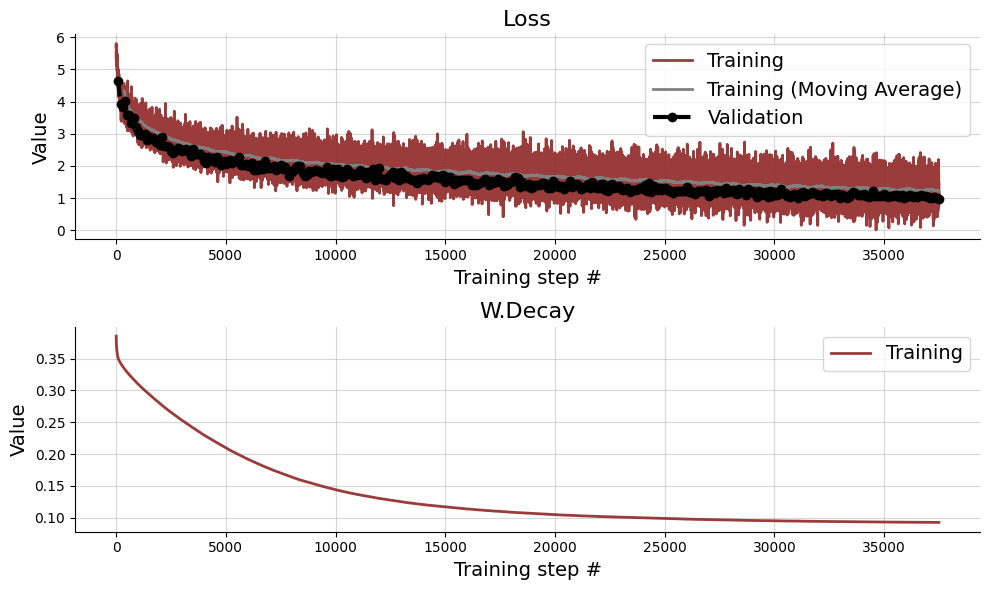

In [51]:
bf.diagnostics.plot_losses(history['train_losses'], history['val_losses'], moving_average=True, fig_size=(10, 6));

In [52]:
# Check if training converged
if np.isnan(history['val_losses'].iloc[-1]).any():
    print('Training failed with NaN loss at the end')
    if np.isnan(history['val_losses'].iloc[-max_to_keep:]).all():
        print('Training failed with NaN loss for all latest checkpoints')

# Find the checkpoint with the lowest validation loss out of the last max_to_keep
recent_losses = history['val_losses'].iloc[-max_to_keep:]
best_valid_epoch = recent_losses['Loss'].idxmin() + 1  # checkpoints are 1-based indexed
new_checkpoint = trainer.manager.latest_checkpoint.rsplit('-', 1)[0] + f'-{best_valid_epoch}'    
trainer.checkpoint.restore(new_checkpoint)
print("Networks loaded from {}".format(new_checkpoint))

Networks loaded from amortizer-cell-migration-attention-7/ckpt-375


# Diagnostic plots

In [53]:
from tarp import get_tarp_coverage
from matplotlib import pyplot as plt

In [54]:
test_sims = trainer.configurator(sim_data)

In [55]:
posterior_samples = amortizer.sample(test_sims, n_samples=100)
posterior_samples = posterior_samples * p_std + p_mean
prior_draws = test_sims["parameters"] * p_std + p_mean

INFO:root:The ratio of simulations / posterior draws should be > 20 for reliable variance reduction, but your ratio is 1.                    Confidence intervals might be unreliable!


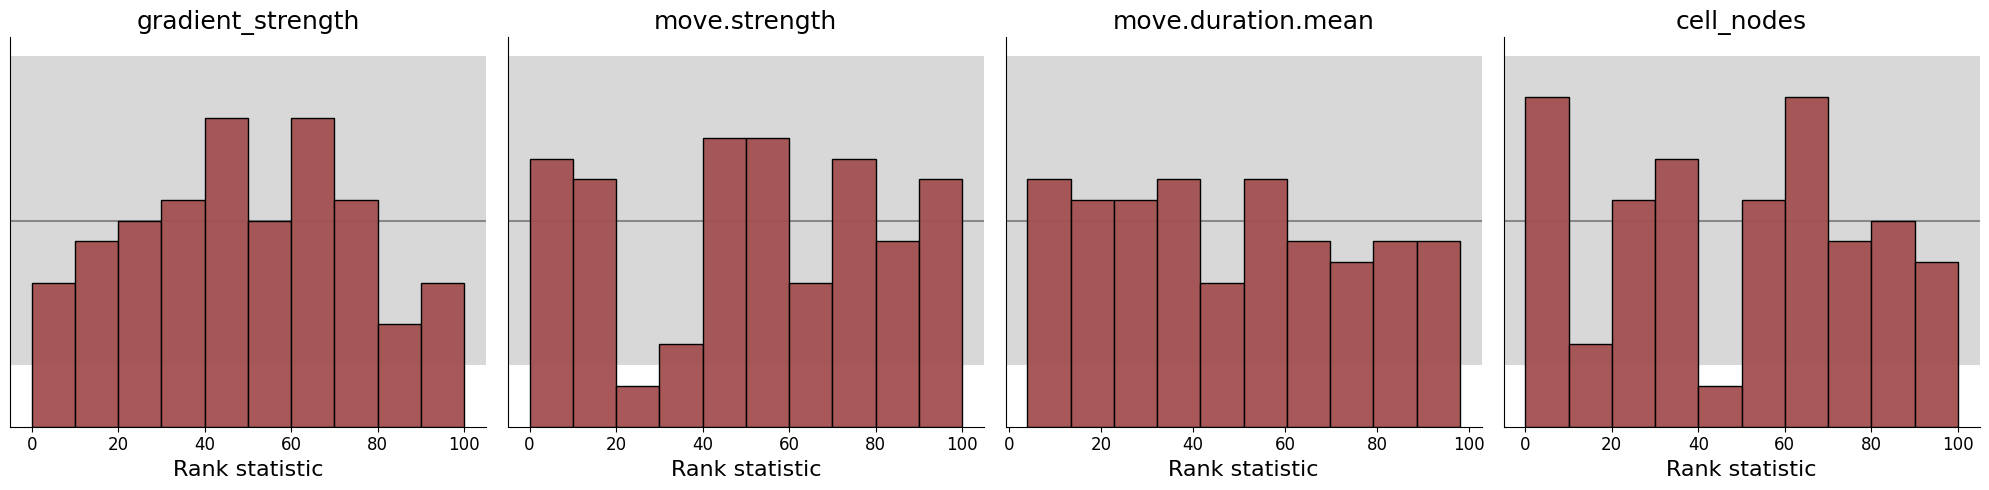

In [56]:
bf.diagnostics.plot_sbc_histograms(posterior_samples, prior_draws, num_bins=10, param_names=param_names);

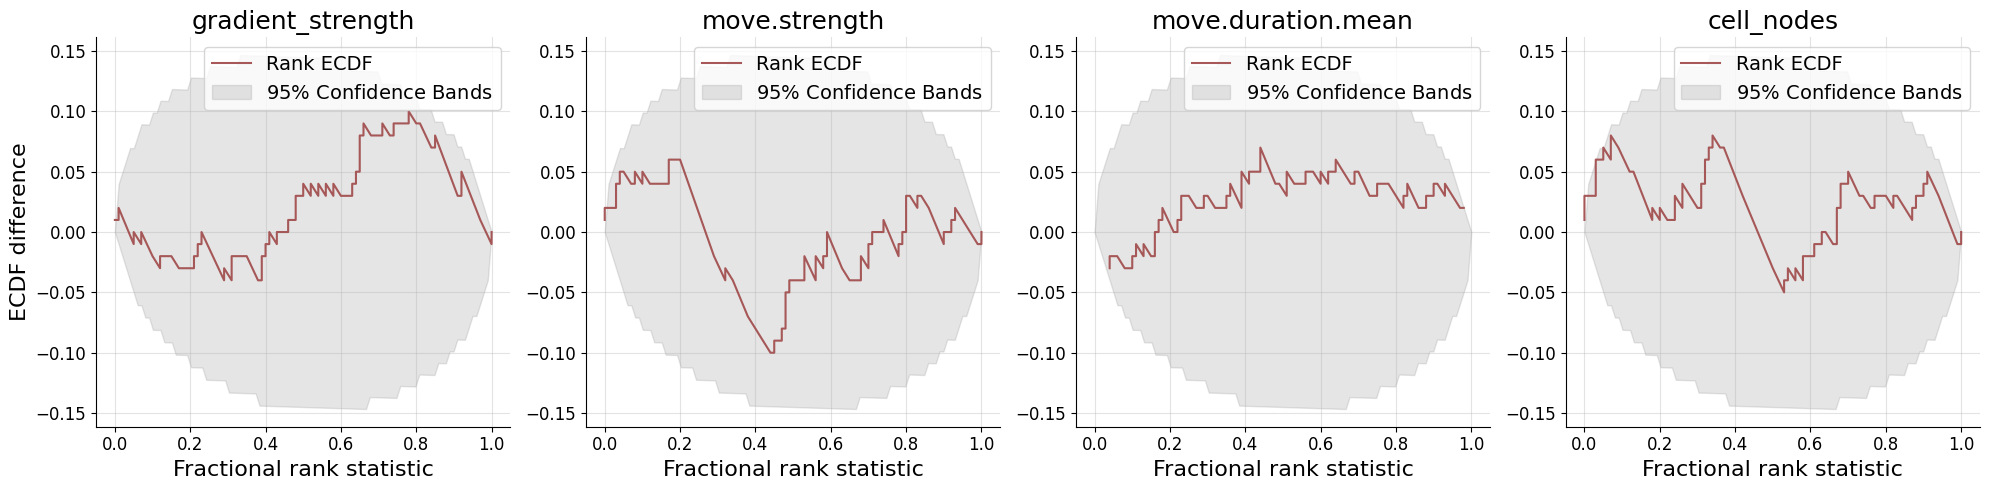

In [57]:
fig = bf.diagnostics.plot_sbc_ecdf(posterior_samples, prior_draws, difference=True, param_names=param_names)
plt.savefig(f'../results/{checkpoint_path}/sbc_ecdf.png')

In [58]:
posterior_samples = amortizer.sample(test_sims, n_samples=1000)
posterior_samples = posterior_samples * p_std + p_mean

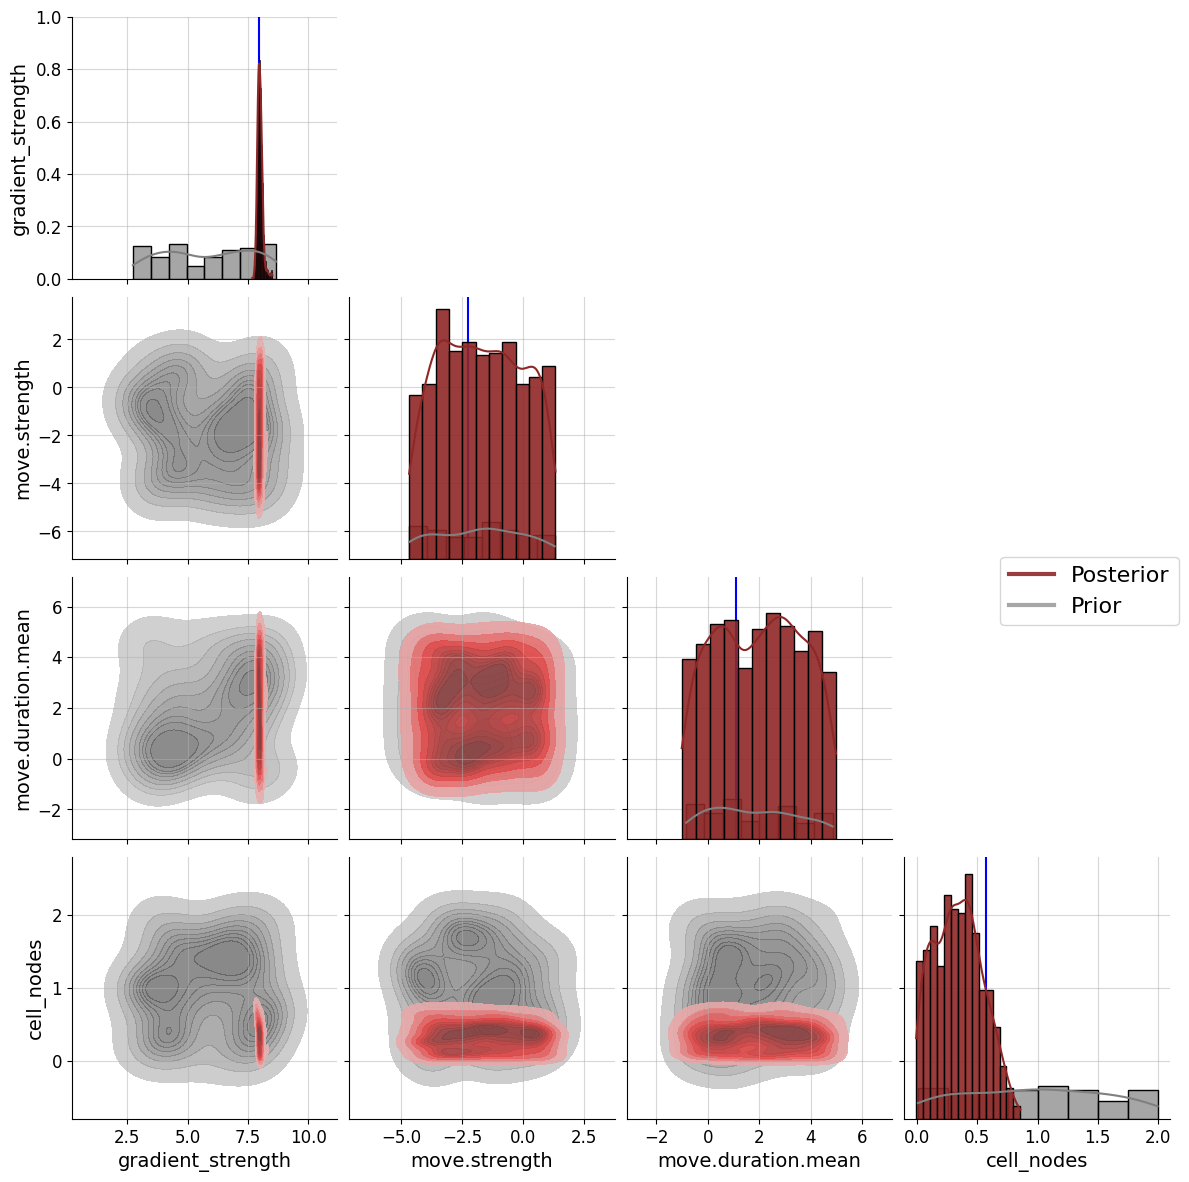

In [59]:
sample_id = 0
fig = bf.diagnostics.plot_posterior_2d(posterior_draws=posterior_samples[sample_id], prior_draws=prior_draws[:posterior_samples.shape[1]],
                                 param_names=param_names)
# from figure get axis
ax = fig.get_axes()
for i, a in enumerate(ax):
    # plot only on the diagonal
    if i == i // len(param_names) * (len(param_names)+1):
        a.axvline(prior_draws[sample_id][i // len(param_names)], color='b', label='True parameter')
plt.show()

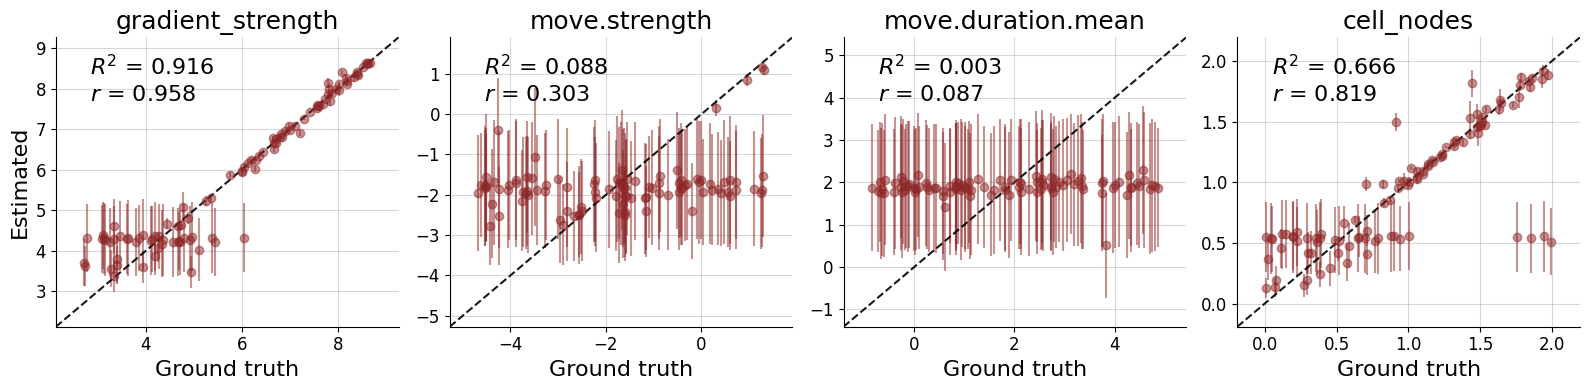

In [60]:
fig = bf.diagnostics.plot_recovery(posterior_samples, prior_draws, param_names=param_names)
plt.savefig(f'../results/{checkpoint_path}/recovery.png')

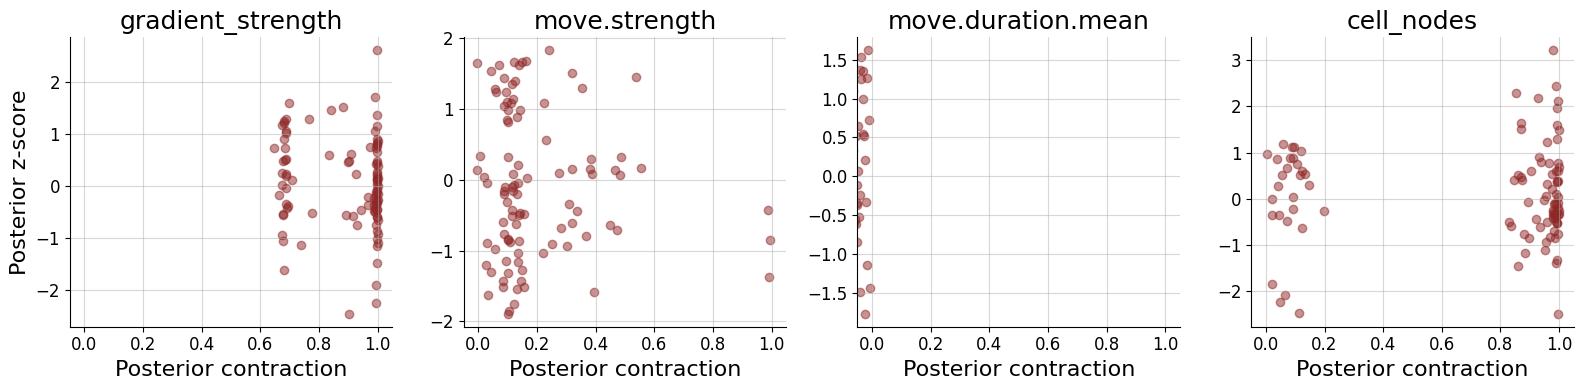

In [61]:
bf.diagnostics.plot_z_score_contraction(posterior_samples, prior_draws, param_names=param_names);

In [62]:
posterior_samples_reshaped = posterior_samples.reshape(posterior_samples.shape[1], posterior_samples.shape[0], posterior_samples.shape[2])

In [63]:
ecp_bootstrap, alpha = get_tarp_coverage(posterior_samples_reshaped, prior_draws, references='random', #posterior_samples_reshaped[0, :, :]
                                         metric='euclidean', norm=True, bootstrap=True)

100%|██████████| 100/100 [00:00<00:00, 282.08it/s]


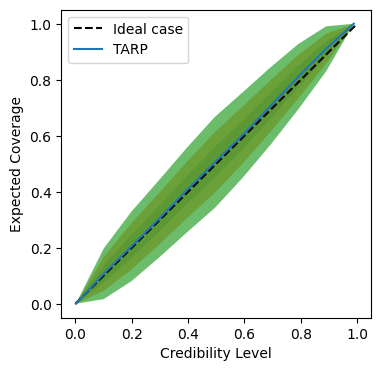

In [64]:
k_sigma = [1, 2, 3]

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot([0, 1], [0, 1], ls='--', color='k', label="Ideal case")
ax.plot(alpha, ecp_bootstrap.mean(axis=0), label='TARP')
for k in k_sigma:
    ax.fill_between(alpha, 
                    ecp_bootstrap.mean(axis=0) - k * ecp_bootstrap.std(axis=0), 
                    ecp_bootstrap.mean(axis=0) + k * ecp_bootstrap.std(axis=0), 
                    alpha = 0.7)
ax.legend()
ax.set_ylabel("Expected Coverage")
ax.set_xlabel("Credibility Level")
plt.show()

# Test on synthetic data

In [65]:
# simulate test data
test_params = np.log10(list(obs_pars.values()))
if not os.path.exists('test_sim.npy'):
    test_sim_full = bayes_simulator(test_params[np.newaxis])
    test_sim = test_sim_full['sim_data']
    np.save('test_sim.npy', test_sim)
else:
    test_sim = np.load('test_sim.npy')
    test_sim_full = {'sim_data': test_sim}
test_sim.shape

(1, 50, 120, 2)

In [66]:
test_posterior_samples = amortizer.sample(trainer.configurator(test_sim_full), n_samples=100)
test_posterior_samples = test_posterior_samples * p_std + p_mean

# compute the log posterior of the test data
input_dict = {
    'sim_data': np.repeat(test_sim, repeats=100, axis=0),
    'parameters': test_posterior_samples
}
log_prob = amortizer.log_posterior(trainer.configurator(input_dict))
    
# get the MAP
map_idx = np.argmax(log_prob)

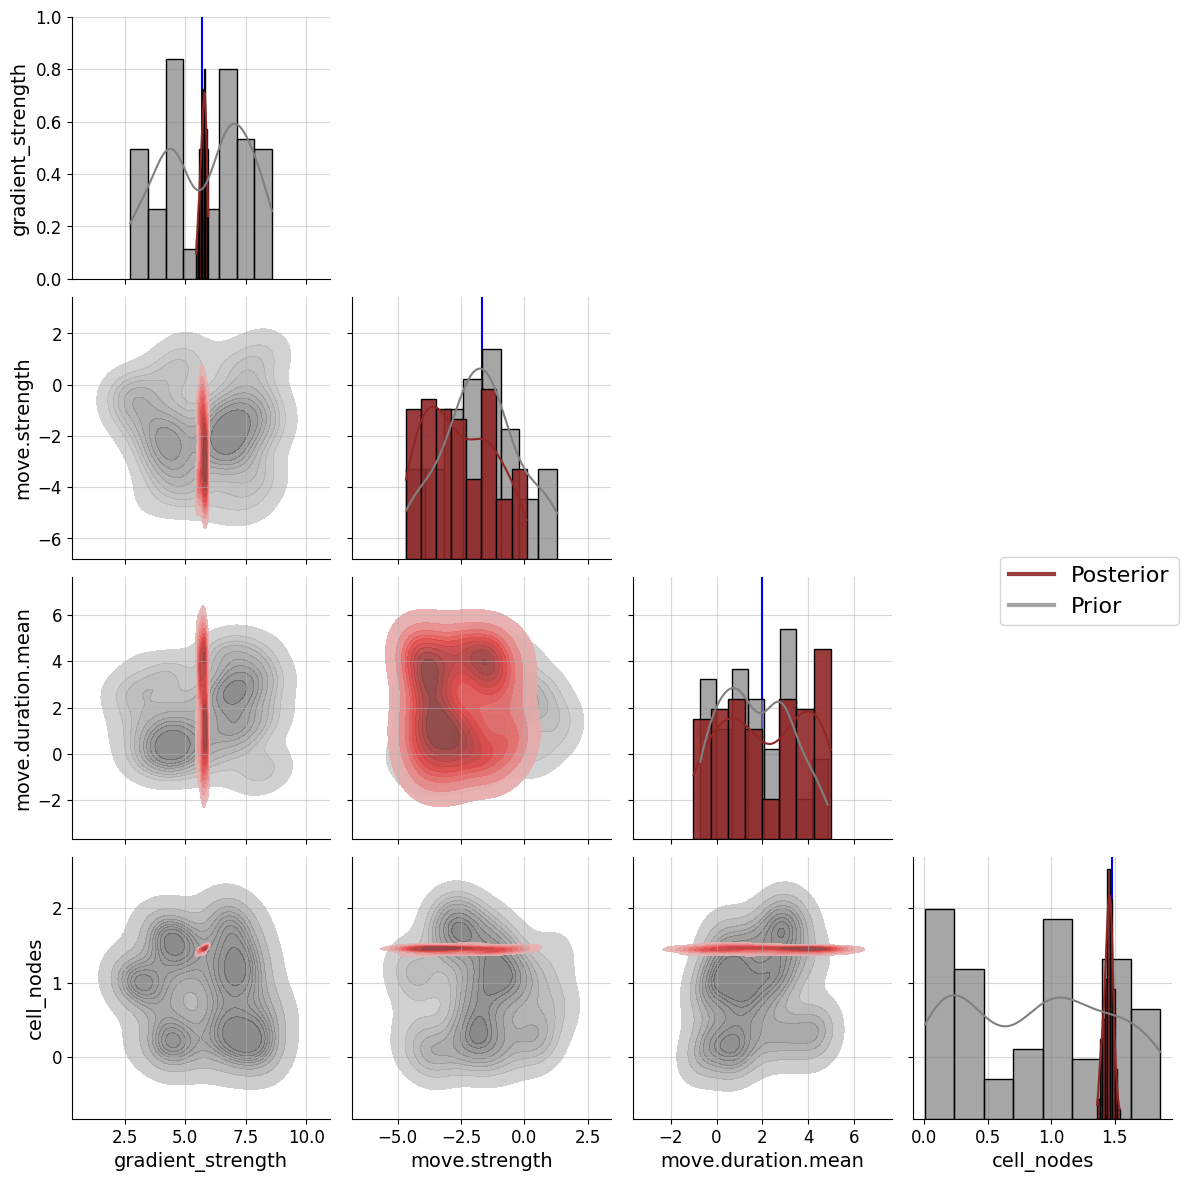

In [67]:
fig = bf.diagnostics.plot_posterior_2d(posterior_draws=test_posterior_samples,
                                       prior_draws=prior_draws[:test_posterior_samples.shape[0]],
                                       param_names=param_names)
# from figure get axis
ax = fig.get_axes()
for i, a in enumerate(ax):
    # plot only on the diagonal
    if i == i // len(param_names) * (len(param_names)+1):
        a.axvline(test_params[i // len(param_names)], color='b', label='True parameter')
plt.savefig(f'../results/{checkpoint_path}/posterior_vs_prior.png')
plt.show()

In [68]:
# get posterior samples and simulate
if not os.path.exists(checkpoint_path+'/posterior_sim.npy'):
    # simulate the data
    posterior_sim = bayes_simulator(test_posterior_samples)['sim_data']
    np.save(checkpoint_path+'/posterior_sim.npy', posterior_sim)
    
    print('map_sim', map_idx, log_prob[map_idx], test_posterior_samples[map_idx])
else:
    posterior_sim = np.load(checkpoint_path+'/posterior_sim.npy')
    map_sim = posterior_sim[map_idx_sim]

In [69]:
# compute the summary statistics
synthetic_summary_stats_list = [reduced_coordinates_to_sumstat(t) for t in test_sim]  # should be only one population
simulation_synth_summary_stats_list = [reduced_coordinates_to_sumstat(pop_sim) for pop_sim in posterior_sim]

# compute the mean of the summary statistics
ad_mean_synth, MSD_mean_synth, TA_mean_synth, VEL_mean_synth, ad_mean_synth_averg, MSD_mean_synth_averg, TA_mean_synth_averg, VEL_mean_synth_averg = compute_mean_summary_stats(synthetic_summary_stats_list)
ad_mean_synth_sim, MSD_mean_synth_sim, TA_mean_synth_sim, VEL_mean_synth_sim, ad_mean_synth_sim_averg, MSD_mean_synth_sim_averg, TA_mean_synth_sim_averg, VEL_mean_synth_sim_averg = compute_mean_summary_stats(simulation_synth_summary_stats_list)

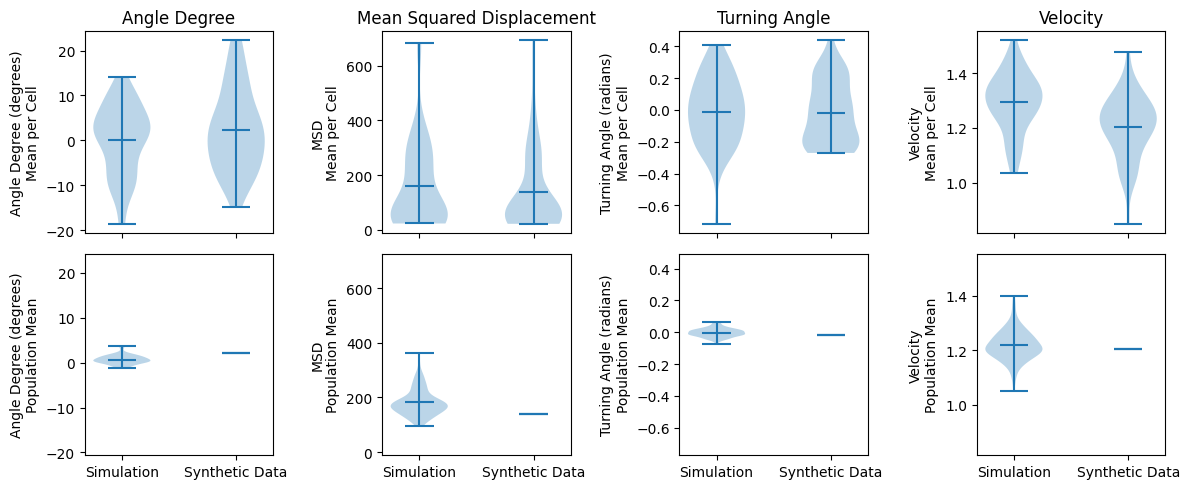

Angle Degree KS Statistic: 0.18
Angle Degree P-value: 0.3959398631708505, False: different distributions
MSD KS Statistic: 0.72
MSD P-value: 0.588235294117647, False: different distributions
Turning Angle KS Statistic: 0.14
Turning Angle P-value: 0.7166468440414822, False: different distributions
Velocity KS Statistic: 0.42
Velocity P-value: 0.0002460240344273171, True: different distributions


In [70]:
# plot the summary statistics
fig, ax = plt.subplots(nrows=2, ncols=4, sharex=True, sharey='col', tight_layout=True, figsize=(12, 5))
ax[0, 0].violinplot([ad_mean_synth_sim[map_idx_sim], ad_mean_synth[0]], showmeans=True)
ax[0, 0].set_title(f'Angle Degree')
ax[0, 0].set_ylabel(f'Angle Degree (degrees)\nMean per Cell')
ax[1, 0].violinplot([ad_mean_synth_sim_averg, ad_mean_synth_averg], showmeans=True)
ax[1, 0].set_ylabel(f'Angle Degree (degrees)\nPopulation Mean')
ax[1, 0].set_xticks([1, 2], ['Simulation', 'Synthetic Data'])

ax[0, 1].violinplot([MSD_mean_synth_sim[map_idx_sim], MSD_mean_synth[0]], showmeans=True)
ax[0, 1].set_title(f'Mean Squared Displacement')
ax[0, 1].set_ylabel(f'MSD\nMean per Cell')
ax[1, 1].violinplot([MSD_mean_synth_sim_averg, MSD_mean_synth_averg], showmeans=True)
ax[1, 1].set_ylabel(f'MSD\nPopulation Mean')
ax[1, 1].set_xticks([1, 2], ['Simulation', 'Synthetic Data'])

ax[0, 2].violinplot([TA_mean_synth_sim[map_idx_sim], TA_mean_synth[0]], showmeans=True)
ax[0, 2].set_title(f'Turning Angle')
ax[0, 2].set_ylabel(f'Turning Angle (radians)\nMean per Cell')
ax[1, 2].violinplot([TA_mean_synth_sim_averg, TA_mean_synth_averg], showmeans=True)
ax[1, 2].set_ylabel(f'Turning Angle (radians)\nPopulation Mean')
ax[1, 2].set_xticks([1, 2], ['Simulation', 'Synthetic Data'])

ax[0, 3].violinplot([VEL_mean_synth_sim[map_idx_sim], VEL_mean_synth[0]], showmeans=True)
ax[0, 3].set_title(f'Velocity')
ax[0, 3].set_ylabel(f'Velocity\nMean per Cell')
ax[1, 3].violinplot([VEL_mean_synth_sim_averg, VEL_mean_synth_averg], showmeans=True)
ax[1, 3].set_ylabel(f'Velocity\nPopulation Mean')
ax[1, 3].set_xticks([1, 2], ['Simulation', 'Synthetic Data'])
plt.savefig(f'../results/{checkpoint_path}/Summary Stats.png')
plt.show()

# Perform the Kolmogorov-Smirnov test
ks_statistic, p_value = stats.ks_2samp(ad_mean_synth_sim[map_idx_sim], ad_mean_synth[0])
print(f"Angle Degree KS Statistic: {ks_statistic}")
print(f"Angle Degree P-value: {p_value}, {p_value < 0.05}: different distributions")

ks_statistic, p_value = stats.ks_2samp(MSD_mean_synth_sim_averg[map_idx_sim], MSD_mean_synth[0])
print(f"MSD KS Statistic: {ks_statistic}")
print(f"MSD P-value: {p_value}, {p_value < 0.05}: different distributions")

ks_statistic, p_value = stats.ks_2samp(TA_mean_synth_sim[map_idx_sim], TA_mean_synth[0])
print(f"Turning Angle KS Statistic: {ks_statistic}")
print(f"Turning Angle P-value: {p_value}, {p_value < 0.05}: different distributions")

ks_statistic, p_value = stats.ks_2samp(VEL_mean_synth_sim[map_idx_sim], VEL_mean_synth[0])
print(f"Velocity KS Statistic: {ks_statistic}")
print(f"Velocity P-value: {p_value}, {p_value < 0.05}: different distributions")

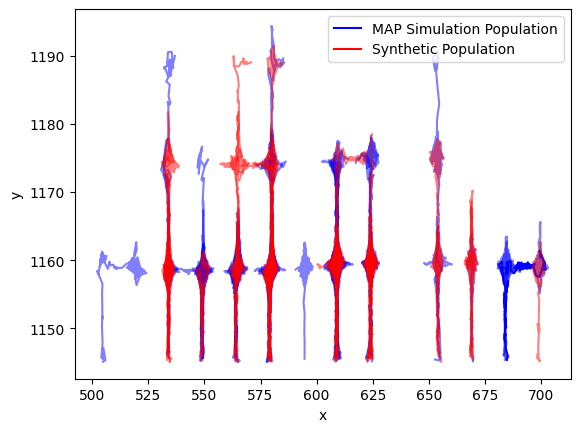

In [71]:
# plot the simulations or the MAP
plt.plot(map_sim[0, :, 0], map_sim[0, :, 1], 'b', label='MAP Simulation Population', alpha=1)
for cell_id in range(1, data_dim):           
    plt.plot(map_sim[cell_id, :, 0], map_sim[cell_id, :, 1], 'b', alpha=0.5)
    
# plot the synthetic data
plt.plot(test_sim[0][0, :, 0], test_sim[0][0, :, 1], 'r', label='Synthetic Population', alpha=1)
for cell_id in range(1, data_dim):           
    plt.plot(test_sim[0][cell_id, :, 0], test_sim[0][cell_id, :, 1], 'r', alpha=0.5)
    
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.savefig(f'../results/{checkpoint_path}/Simulations.png')
plt.show()

# Real Data

In [81]:
# load real data
real_data_id = [0, 1][1]
if real_data_id == 0:
    real_data_df = pd.read_csv('../real_data/37C-1_crop.csv')
else:
    real_data_df = pd.read_csv('../real_data/37C_ctrl2.csv')
# remove first three rows
real_data_df = real_data_df.iloc[3:]
# only keep positions and time
real_data_df = real_data_df[['TRACK_ID', 'POSITION_X', 'POSITION_Y', 'POSITION_T']]
# convert to numeric
real_data_df = real_data_df.apply(pd.to_numeric, errors='coerce')

# scale to morpheus coordinates
real_data_df['x'] = real_data_df['POSITION_X'] / 1.31 + 415/1.31 # todo: ask Emad about the offset
real_data_df['y'] = real_data_df['POSITION_Y'] / 1.31 + 1500/1.31

In [82]:
real_data = np.ones((real_data_df.TRACK_ID.nunique(), max_sequence_length, 2)) * np.nan
# each cell is of different length, each with x and y coordinates, make a tensor out of it
for s_id, sample in enumerate(real_data_df.TRACK_ID.unique()):
    cell = real_data_df[real_data_df.TRACK_ID == sample]
    # order by time
    cell = cell.sort_values('POSITION_T', ascending=False)
    #cell = cut_region(cell, x_min=316.5, x_max=856.5, y_min=1145, y_max=1351, return_longest=True)
    #if cell is None:
    #    continue
    #cell = cell[0]
    # pre-pad the data with zeros, but first write zeros as nans to compute the mean and std
    real_data[s_id, -len(cell['x'][:max_sequence_length]):, 0] = cell['x'][:max_sequence_length]
    real_data[s_id, -len(cell['y'][:max_sequence_length]):, 1] = cell['y'][:max_sequence_length]
    
# order real_data by number of nans, to get data_dim cells with the longest trajectories
n_nans = np.isnan(real_data).sum(axis=(1,2))
order = np.argsort(n_nans)
real_data = real_data[order]
real_data = real_data[:data_dim]

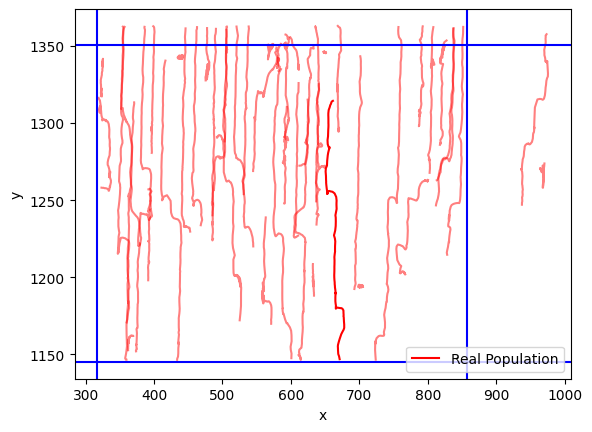

In [83]:
plt.plot(real_data[0, :, 0], real_data[0, :, 1], 'r', label='Real Population', alpha=1)
for cell_id in range(1, real_data.shape[0]):           
    plt.plot(real_data[cell_id, :, 0], real_data[cell_id, :, 1], 'r', alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.axline((415/1.31, 1145), (856.5, 1145), color='b')
plt.axline((415/1.31, 1351), (856.5, 1351), color='b')
plt.axline((415/1.31, 1145), (415/1.31, 1351), color='b')
plt.axline((856.5, 1145), (856.5, 1351), color='b')
plt.legend()
plt.show()

In [84]:
real_posterior_samples = amortizer.sample(trainer.configurator({'sim_data': real_data[np.newaxis]}), 
                                          n_samples=100)
real_posterior_samples = real_posterior_samples * p_std + p_mean

# compute the log posterior of the test data
input_dict = {
    'sim_data': np.repeat(real_data[np.newaxis], repeats=100, axis=0),
    'parameters': real_posterior_samples
}
log_prob = amortizer.log_posterior(trainer.configurator(input_dict))

# get the MAP
map_idx = np.argmax(log_prob)

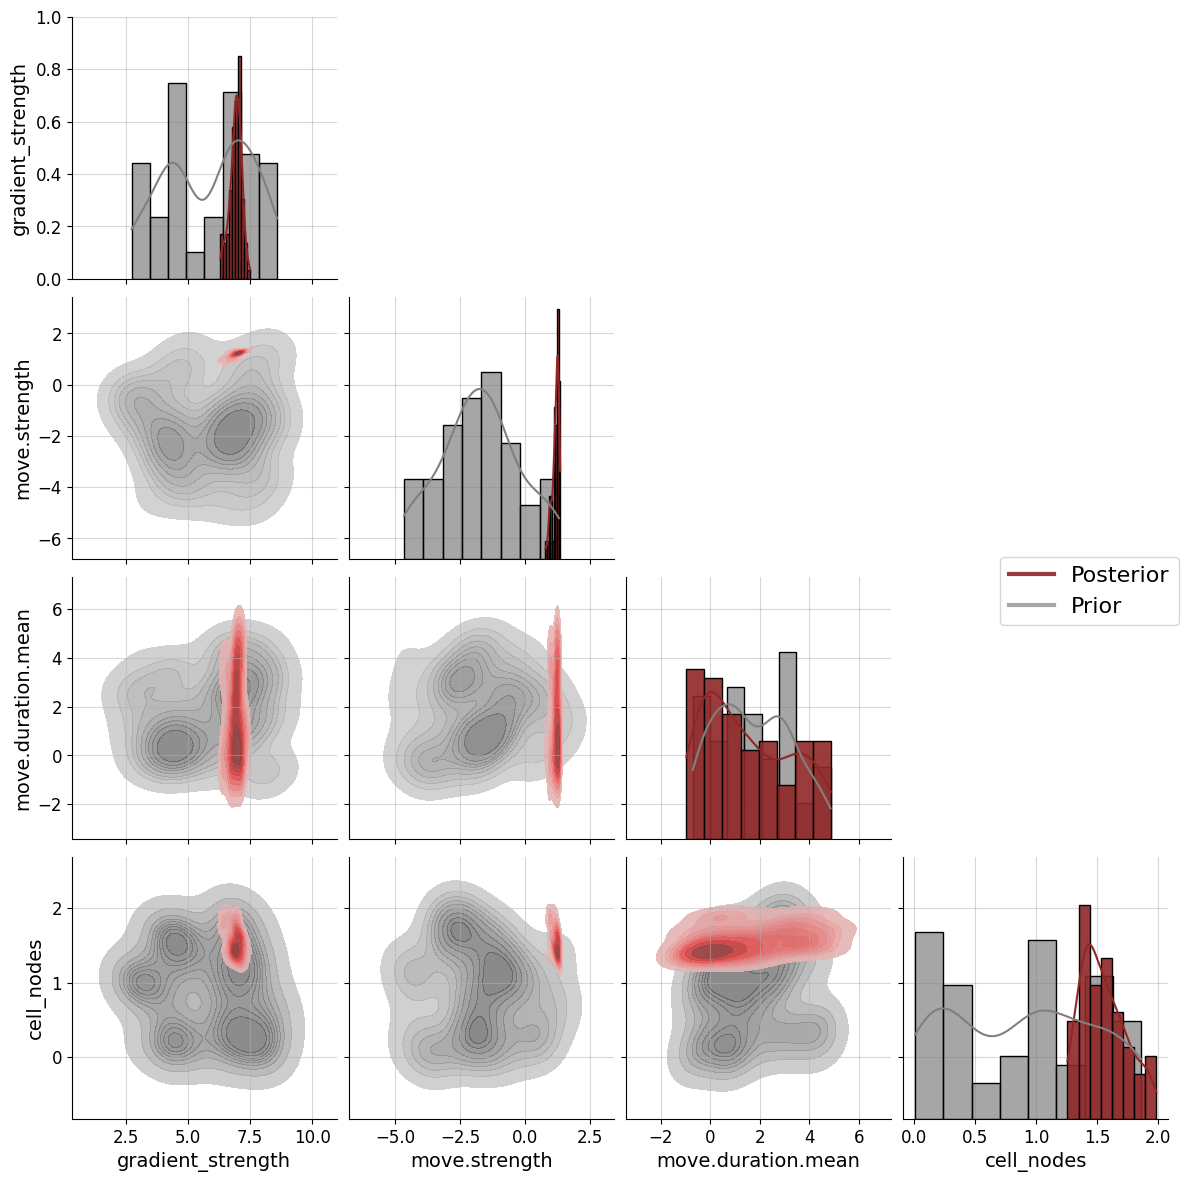

In [85]:
fig = bf.diagnostics.plot_posterior_2d(posterior_draws=real_posterior_samples,
                                       prior_draws=prior_draws[:real_posterior_samples.shape[0]],
                                       param_names=param_names)
plt.savefig(f'../results/{checkpoint_path}/Real_{real_data_id} posterior_vs_prior.png')
plt.show()

In [ ]:
# get posterior samples and simulate
if not os.path.exists(checkpoint_path+f'/posterior_sim_real_{real_data_id}.npy'):
    # simulate the data
    map_sim_real = bayes_simulator(real_posterior_samples[map_idx][np.newaxis])['sim_data'][0]
    np.save(checkpoint_path+f'/posterior_sim_real_{real_data_id}.npy', map_sim_real)
else:
    map_sim_real = np.load(checkpoint_path+f'/posterior_sim_real_{real_data_id}.npy')

In [ ]:
# compute the summary statistics
real_summary_stats_list = [reduced_coordinates_to_sumstat(real_data)]  # should be only one population
simulation_summary_stats_list = [reduced_coordinates_to_sumstat(map_sim_real)]

# compute the mean of the summary statistics
ad_mean_real, MSD_mean_real, TA_mean_real, VEL_mean_real, _, _, _, _ = compute_mean_summary_stats(real_summary_stats_list)
ad_mean_real_sim, MSD_mean_real_sim, TA_mean_real_sim, VEL_mean_real_sim, _, _, _, _ = compute_mean_summary_stats(simulation_summary_stats_list)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, tight_layout=True, figsize=(10, 5))
# plot the simulations or the MAP
ax[1].plot(map_sim_real[0, :, 0], map_sim_real[0, :, 1], 'b', label='MAP Simulation Population', alpha=1)
for cell_id in range(1, data_dim):           
    ax[1].plot(map_sim_real[cell_id, :, 0], map_sim_real[cell_id, :, 1], 'b', alpha=0.5)
    
# plot the synthetic data
ax[0].plot(real_data[0, :, 0], real_data[0, :, 1], 'r', label='Real Population', alpha=1)
for cell_id in range(1, data_dim):           
    ax[0].plot(real_data[cell_id, :, 0], real_data[cell_id, :, 1], 'r', alpha=0.5)
    
ax[0].set_ylabel('y')
for a in ax:
    a.legend()
    a.set_xlabel('x')
plt.savefig(f'../results/{checkpoint_path}/Real_{real_data_id} vs Simulations.png')
plt.show()

In [ ]:
# plot the summary statistics
fig, ax = plt.subplots(nrows=1, ncols=4, sharex=True, sharey='col', tight_layout=True, figsize=(10, 5))
ax[0].violinplot([ad_mean_real_sim[0], ad_mean_real[0]], showmeans=True)
ax[0].set_title(f'Angle Degree')
ax[0].set_ylabel(f'Angle Degree (degrees)\nMean per Cell')
ax[0].set_xticks([1, 2], ['Simulation', 'Real Data'])

ax[1].violinplot([MSD_mean_real_sim[0], MSD_mean_real[0]], showmeans=True)
ax[1].set_title(f'Mean Squared Displacement')
ax[1].set_ylabel(f'MSD\nMean per Cell')
ax[1].set_xticks([1, 2], ['Simulation', 'Real Data'])

ax[2].violinplot([TA_mean_real_sim[0], TA_mean_real[0]], showmeans=True)
ax[2].set_title(f'Turning Angle')
ax[2].set_ylabel(f'Turning Angle (radians)\nMean per Cell')
ax[2].set_xticks([1, 2], ['Simulation', 'Real Data'])

ax[3].violinplot([VEL_mean_real_sim[0], VEL_mean_real[0]], showmeans=True)
ax[3].set_title(f'Velocity')
ax[3].set_ylabel(f'Velocity\nMean per Cell')
ax[3].set_xticks([1, 2], ['Simulation', 'Real Data'])
plt.savefig(f'../results/{checkpoint_path}/Real_{real_data_id} Summary Stats.png')
plt.show()

# Perform the Kolmogorov-Smirnov test
ks_statistic, p_value = stats.ks_2samp(ad_mean_real_sim[0], ad_mean_real[0])
print(f"Angle Degree KS Statistic: {ks_statistic}")
print(f"Angle Degree P-value: {p_value}, {p_value < 0.05}: different distributions")

ks_statistic, p_value = stats.ks_2samp(MSD_mean_real_sim[0], MSD_mean_real[0])
print(f"MSD KS Statistic: {ks_statistic}")
print(f"MSD P-value: {p_value}, {p_value < 0.05}: different distributions")

ks_statistic, p_value = stats.ks_2samp(TA_mean_real_sim[0], TA_mean_real[0])
print(f"Turning Angle KS Statistic: {ks_statistic}")
print(f"Turning Angle P-value: {p_value}, {p_value < 0.05}: different distributions")

ks_statistic, p_value = stats.ks_2samp(VEL_mean_real_sim[0], VEL_mean_real[0])
print(f"Velocity KS Statistic: {ks_statistic}")
print(f"Velocity P-value: {p_value}, {p_value < 0.05}: different distributions")